# Import libraries and data

In [21]:
# import libraries 
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns

from Bio.SeqUtils.ProtParam import ProteinAnalysis
from matplotlib_venn import venn2, venn3
from scipy.stats import mannwhitneyu
from utils import print_p_val

In [22]:
data_path = os.getcwd() + "/Datasets/"
fig_path = os.getcwd() + "/Figures/"

## Curated CSF data sets

In [23]:
csf = pd.read_csv(data_path + "CSF/csf.csv")
print("Number of proteins in CSF data set:", len(csf))

Number of proteins in CSF data set: 5724


In [24]:
all_csf = pd.read_csv(data_path + "CSF/all_csf.csv")
print("Number of proteins in all CSF data set:", len(all_csf))

Number of proteins in all CSF data set: 5781


In [25]:
csf_seq = pd.read_csv(data_path + "CSF/csf_Uniprot_seq.tab", sep="\t", header=0, names=["Uniprot", "Sequence"])
# drop entries without sequence (obsolete)
csf_seq.dropna(subset=["Sequence"], inplace=True) # 8 entries dropped
# drop entries with non-standard amino acids
csf_seq = csf_seq[csf_seq["Sequence"].str.contains("B|U|X") == False] # 10 entries dropped
print("Number of CSF proteins with associated Uniprot and sequence:", len(csf_seq))

Number of CSF proteins with associated Uniprot and sequence: 5629


### Schilde et al. (2018) CSF core proteome

In [26]:
csf_core_schilde2018 = pd.read_csv(data_path + "CSF/Schilde2018_CSF_core_proteins_244.csv", sep=";")
csf_core_schilde2018.dropna(axis=0, how="all", inplace=True)
csf_core_schilde2018.dropna(subset=["merged table of compositional CSF proteins"], axis=0, how="all", inplace=True)
print("Number of CSF core proteins in dataset:", len(csf_core_schilde2018))

Number of CSF core proteins in dataset: 243


## Brain data sets

In [27]:
brain_elevated = pd.read_csv(data_path + "Brain/Brain_elevated.csv")
brain_detected = pd.read_csv(data_path + "Brain/Brain_detected.csv")
brain_exclusive = pd.read_csv(data_path + "Brain/Brain_exclusive.csv")

In [28]:
brain_seq = pd.read_csv(data_path + "Brain/Human_brain_elevated_Uniprot_seq.csv", sep=";", header=0, 
    names=["Uniprot", "Sequence"])
# drop entries without sequence (obsolete)
brain_seq.dropna(subset=["Sequence"], inplace=True) # 3 entries dropped
# drop entries with non-standard amino acids
brain_seq = brain_seq[brain_seq["Sequence"].str.contains("B|U|X") == False] # 1 entry dropped
print("Number of brain elevated proteins with associated Uniprot and sequence:", len(brain_seq))

Number of brain elevated proteins with associated Uniprot and sequence: 2542


## Plasma proteome (HBFP)

In [29]:
plasma = pd.read_csv(data_path + "Blood/extended_plasma.csv") # from Renske's project

## ProteomicsDB

In [30]:
# load evidence ProteomicsDB dictionary
with open(data_path + "ProteomicsDB/ProteomicsDB_evidence_positive.txt") as f:
    ProteomicsDB_evidence_positive = json.load(f)

# Data exploration

## Count number of studies

In [31]:
uniprots_csf_studies = {}

# create UniProt lists for each data set
for col in all_csf.columns[1:13]:
    csf_study = all_csf[["Uniprot", col]]
    csf_study.dropna(subset=[col], inplace=True)
    uniprots = set(csf_study["Uniprot"].values)
    uniprots_csf_studies[col] = uniprots

C:\Users\kathi\anaconda3\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


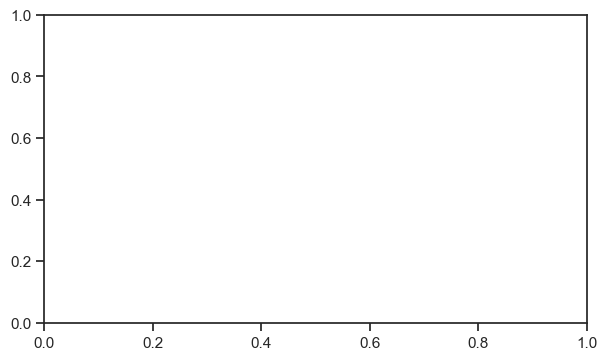

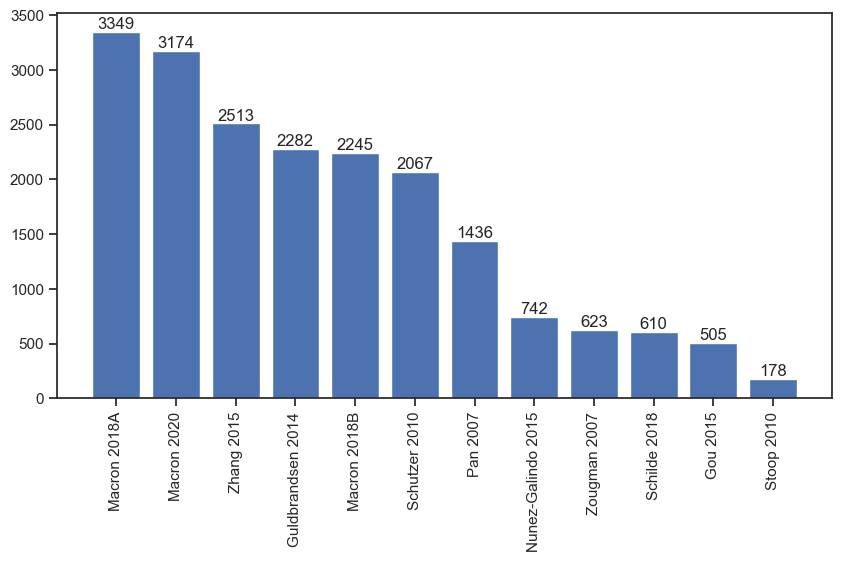

In [32]:
sns.set(style=("ticks"), font_scale=1)
fig, ax = plt.subplots(1, 1, figsize=(10,5))

study_names = ["Macron 2018A", "Macron 2020", "Zhang 2015", "Guldbrandsen 2014", "Macron 2018B", "Schutzer 2010", 
               "Pan 2007", "Nunez-Galindo 2015", "Zougman 2007", "Schilde 2018", "Gou 2015", "Stoop 2010"]

bars = plt.bar(x=study_names, height=[len(uniprots_csf_studies[i]) for i in uniprots_csf_studies.keys()])
ax.bar_label(bars)
plt.xticks(rotation=90)
plt.show()

fig.savefig(fig_path + "Peptide_count_per_study.png", bbox_inches="tight")

## Minimum number of studies per protein

In [33]:
def count_proteins(df):
    """
    Function counts the size of the CSF proteome with specific stringency criteria
    """
    count = []
    labels = []
    for i in range(1, df["#Studies"].max()+1):
        numprot = len(df[df["#Studies"]>=i]) # count how many proteins are identified
        count.append(numprot)
        labels.append("≥" + str(i))
    return labels, count

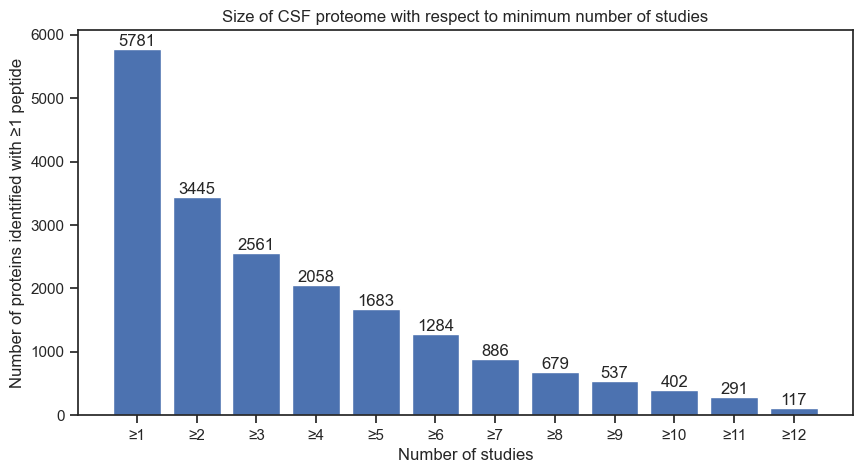

In [34]:
sns.set(style=("ticks"), font_scale=1)
fig, ax = plt.subplots(1, 1, figsize=(10,5))

labels, study_count = count_proteins(all_csf)

bars = ax.bar(x=labels, height=study_count)#, color=["skyblue", "steelblue", "darkcyan", "darkgreen", "mediumseagreen", "palegreen", "yellowgreen"], edgecolor="black")
ax.bar_label(bars, fmt="%.0f")
plt.xlabel("Number of studies")
plt.ylabel("Number of proteins identified with ≥1 peptide")
plt.title("Size of CSF proteome with respect to minimum number of studies")
plt.show()

fig.savefig(fig_path + "Studies_per_protein_all.png", bbox_inches="tight")

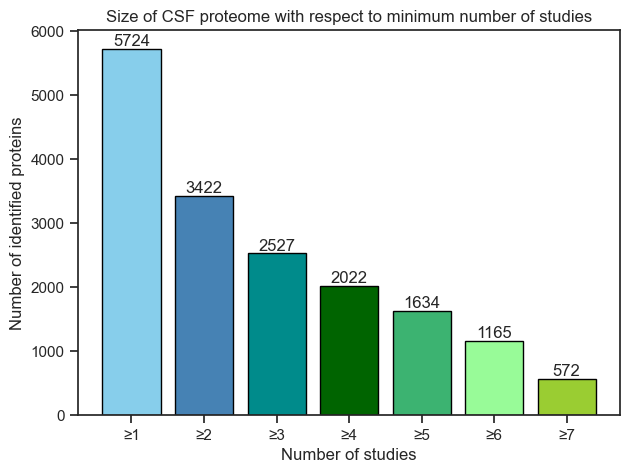

In [35]:
sns.set(style=("ticks"), font_scale=1)
fig, ax = plt.subplots(1, 1, figsize=(7,5))

# count number of proteins per minimum number of studies
labels, study_count = count_proteins(csf)

bars = ax.bar(x=labels, height=study_count, color=["skyblue", "steelblue", "darkcyan", "darkgreen", "mediumseagreen", 
    "palegreen", "yellowgreen"], edgecolor="black")
ax.bar_label(bars, fmt="%.0f")
plt.xlabel("Number of studies")
plt.ylabel("Number of identified proteins")
plt.title("Size of CSF proteome with respect to minimum number of studies")
plt.show()



fig.savefig(fig_path + "Studies_per_protein_1000plus.png", bbox_inches="tight", dpi=300)

## Number of peptides per protein

In [36]:
# median, maximum and minimum number of peptides per CSF protein
csf["#Peptides_median"] = csf[["#Peptides_Macron2018A", "#Peptides_Macron2020", "#Peptides_Zhang2015",
    "#Peptides_Guldbrandsen2014", "#Peptides_Macron2018B", "#Peptides_Schutzer2010", "#Peptides_Pan2007"]].median(axis=1)
csf["#Peptides_max"] = csf[["#Peptides_Macron2018A", "#Peptides_Macron2020", "#Peptides_Zhang2015",
    "#Peptides_Guldbrandsen2014", "#Peptides_Macron2018B", "#Peptides_Schutzer2010", "#Peptides_Pan2007"]].max(axis=1)
csf["#Peptides_min"] = csf[["#Peptides_Macron2018A", "#Peptides_Macron2020", "#Peptides_Zhang2015",
    "#Peptides_Guldbrandsen2014", "#Peptides_Macron2018B", "#Peptides_Schutzer2010", "#Peptides_Pan2007"]].min(axis=1)

In [37]:
csf[(csf["#Studies"] == 1) & (csf["#Peptides_max"] == 1)]

,Uniprot,#Peptides_Macron2018A,#Peptides_Macron2020,#Peptides_Zhang2015,#Peptides_Guldbrandsen2014,#Peptides_Macron2018B,#Peptides_Schutzer2010,#Peptides_Pan2007,#Studies,#Peptides_median,#Peptides_max,#Peptides_min
8,C9JJH3,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1,1.0,1.0,1.0
13,Q96A44,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1,1.0,1.0,1.0
22,Q9GZN2,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1,1.0,1.0,1.0
25,Q9NX14,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1,1.0,1.0,1.0
29,Q96RD7,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
5719,Q9ULJ1,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1,1.0,1.0,1.0
5720,Q9BTA9,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1,1.0,1.0,1.0
5721,Q86VF7,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1,1.0,1.0,1.0
5722,Q8NDV3,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1,1.0,1.0,1.0


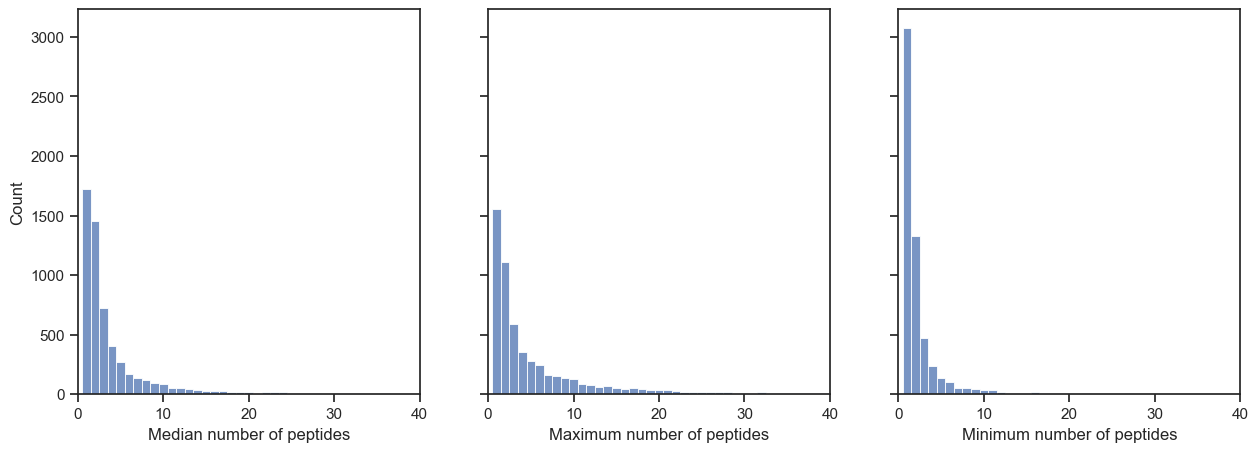

In [38]:
sns.set(style=("ticks"), font_scale=1)
fig, ax = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(15,5))
plt.xlim((0,40))

sns.histplot(data=csf, x="#Peptides_median", discrete=True, ax=ax[0])
ax[0].set(xlabel="Median number of peptides")
sns.histplot(data=csf, x="#Peptides_max", discrete=True, ax=ax[1])
ax[1].set(xlabel="Maximum number of peptides")
sns.histplot(data=csf, x="#Peptides_min", discrete=True, ax=ax[2])
ax[2].set(xlabel="Minimum number of peptides")
plt.show()

## Study overlap

In [39]:
overlap_array = np.zeros((len(uniprots_csf_studies), len(uniprots_csf_studies)))

for i, study_1 in enumerate(uniprots_csf_studies.keys()):
    
    for j, study_2 in enumerate(uniprots_csf_studies.keys()):
        intersec = uniprots_csf_studies[study_1].intersection(uniprots_csf_studies[study_2])
        overlap = len(intersec)/len(uniprots_csf_studies[study_1])
        overlap_array[i,j] = overlap

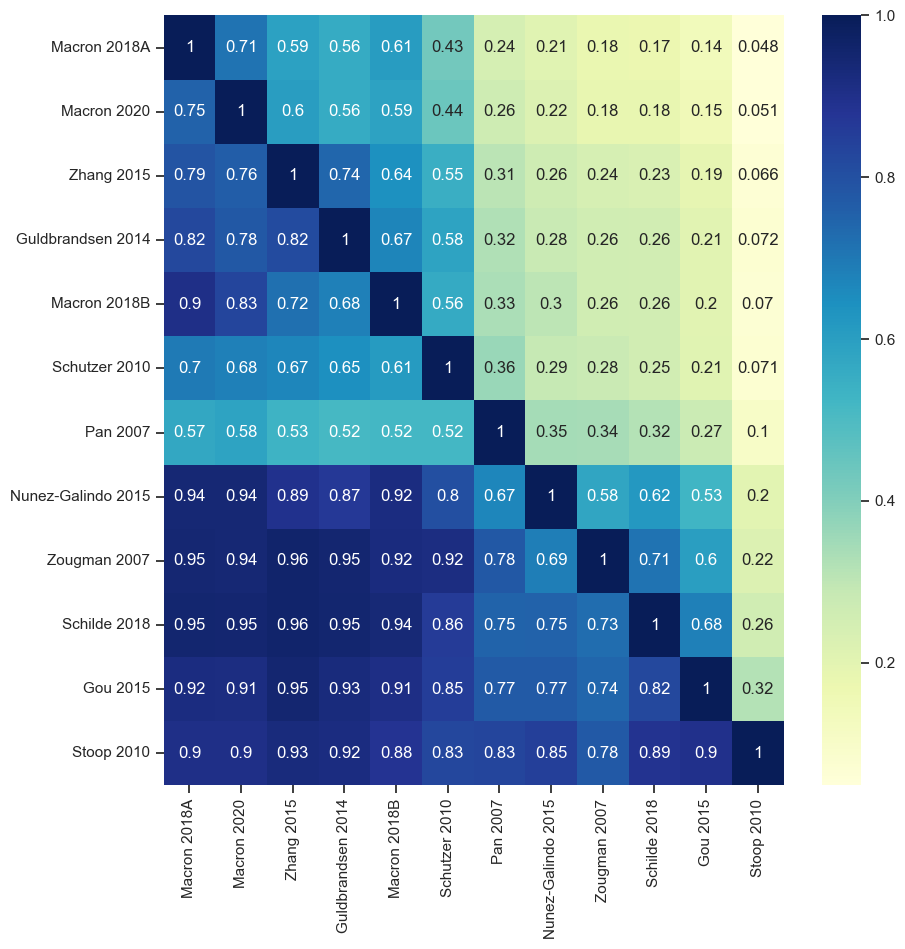

In [40]:
sns.set(style=("ticks"), font_scale=1)
fig, axs = plt.subplots(1, 1, figsize=(10,10))

sns.heatmap(overlap_array, annot=True, xticklabels=study_names, yticklabels=study_names, cmap="YlGnBu")
plt.show()

fig.savefig(fig_path + "Study_overlap_heatmap.png", bbox_inches="tight")

In [41]:
keys_1000plus = ["#Peptides_Macron2018A", "#Peptides_Macron2020", "#Peptides_Zhang2015", "#Peptides_Guldbrandsen2014", 
"#Peptides_Macron2018B", "#Peptides_Schutzer2010", "#Peptides_Pan2007"]

uniprots_csf_studies_1000plus = {keep_key:uniprots_csf_studies[keep_key] for keep_key in keys_1000plus}
uniprots_csf_studies_1000plus.keys()

dict_keys(['#Peptides_Macron2018A', '#Peptides_Macron2020', '#Peptides_Zhang2015', '#Peptides_Guldbrandsen2014', '#Peptides_Macron2018B', '#Peptides_Schutzer2010', '#Peptides_Pan2007'])

In [42]:
overlap_array_1000plus = np.zeros((len(uniprots_csf_studies_1000plus), len(uniprots_csf_studies_1000plus)))

for i, study_1 in enumerate(uniprots_csf_studies_1000plus.keys()):
    
    for j, study_2 in enumerate(uniprots_csf_studies_1000plus.keys()):
        intersec = uniprots_csf_studies_1000plus[study_1].intersection(uniprots_csf_studies_1000plus[study_2])
        overlap = len(intersec)/len(uniprots_csf_studies[study_1])
        overlap_array_1000plus[i,j] = overlap

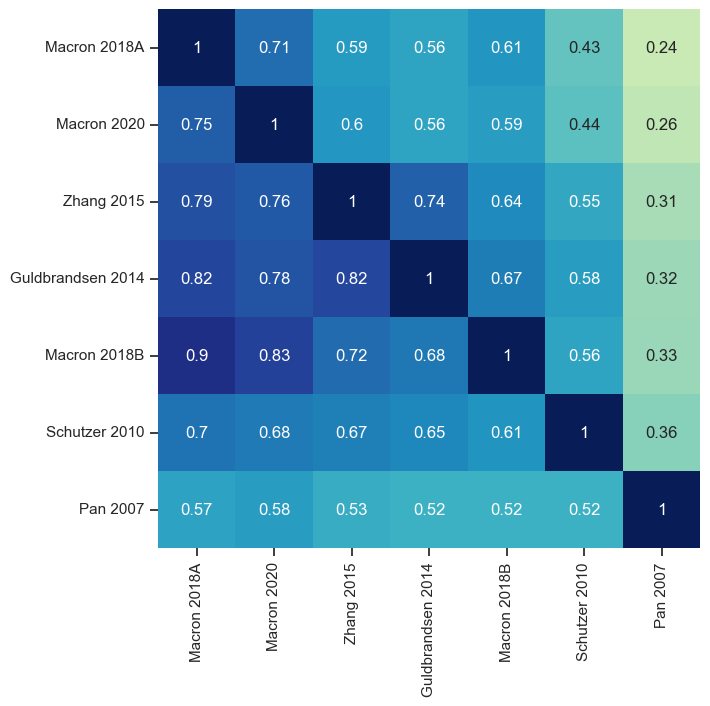

In [43]:
sns.set(style=("ticks"), font_scale=1)
fig, axs = plt.subplots(1, 1, figsize=(7,7))

sns.heatmap(overlap_array_1000plus, annot=True, xticklabels=study_names[:7], yticklabels=study_names[:7], vmin=0, vmax=1, 
    cmap="YlGnBu", cbar=False) # is the bar necessary or not?
plt.show() 

fig.savefig(fig_path + "Study_overlap_heatmap_1000plus.png", bbox_inches="tight", dpi=300)

## CSF and brain proteome overlap

In [44]:
brain_elevated_set = set(brain_elevated["Uniprot"])
brain_detected_set = set(brain_detected["Uniprot"])
brain_exclusive_set = set(brain_exclusive["Uniprot"])
all_csf_set = set(all_csf["Uniprot"])
csf_set = set(csf["Uniprot"])
plasma_set = set(plasma["UniProt"])

In [45]:
# save positive and negative protein list
brain_csf_yes = brain_elevated_set.intersection(csf_set)
print("Number of brain proteins found in CSF:", len(brain_csf_yes))
brain_csf_no = brain_elevated_set.difference(csf_set)
print("Number of brain proteins not found in CSF:", len(brain_csf_no))

Number of brain proteins found in CSF: 996
Number of brain proteins not found in CSF: 1550


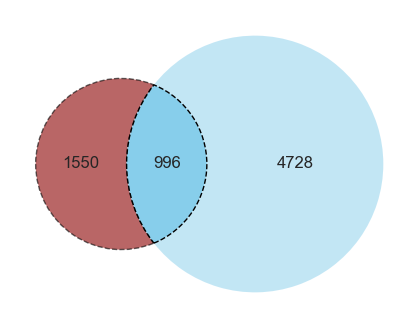

In [46]:
#### CSF society meeting 2022 poster ####

sns.set(style=("ticks"), font_scale=1)
fig, axes = plt.subplots(1, 1, figsize=(6, 4))
colors=("darkred", "skyblue")
alpha = 0.5

# entire dataset
v = venn2([brain_elevated_set, csf_set], ["", ""], set_colors=colors, alpha=alpha)
v.get_patch_by_id("11").set_color("skyblue")
v.get_patch_by_id("11").set_alpha(1.0)
v.get_patch_by_id("11").set_linestyle("dashed")
v.get_patch_by_id("11").set_edgecolor("black")
v.get_patch_by_id("10").set_linestyle("dashed")
v.get_patch_by_id("10").set_edgecolor("black")
v.get_patch_by_id("10").set_alpha(0.6)
plt.show()

fig.savefig(fig_path + "Venn_overlap_brain_elevated_CSF.png", bbox_inches="tight", dpi=300)

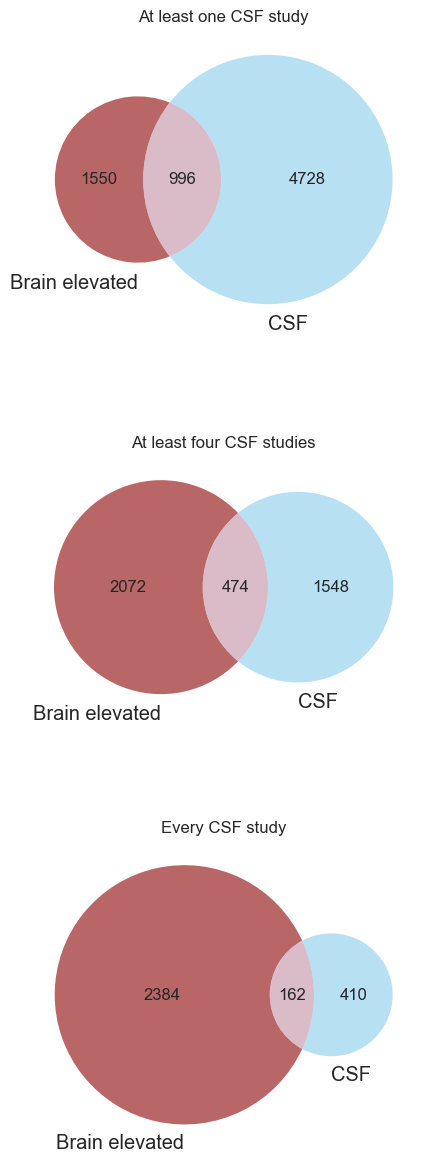

In [47]:
sns.set(style=("ticks"), font_scale=1)
fig, axes = plt.subplots(3, 1, figsize=(5, 15))
colors=("darkred", "skyblue")
alpha = 0.6

venn2([brain_elevated_set, csf_set], ["Brain elevated", "CSF"], ax=axes[0], set_colors=colors, alpha=alpha)
axes[0].set(title="At least one CSF study")

half_csf_set = set(csf[csf["#Studies"]>=4]["Uniprot"])
venn2([brain_elevated_set, half_csf_set], ["Brain elevated", "CSF"], ax=axes[1], set_colors=colors, 
    alpha=alpha)
axes[1].set(title="At least four CSF studies")

every_csf_set = set(csf[csf["#Studies"]>=7]["Uniprot"])
venn2([brain_elevated_set, every_csf_set], ["Brain elevated", "CSF"], ax=axes[2], set_colors=colors, 
    alpha=alpha)
axes[2].set(title="Every CSF study")

plt.show()
fig.savefig(fig_path + "Venn_diagrams_overlap_brain_elevated_CSF.png", bbox_inches="tight")

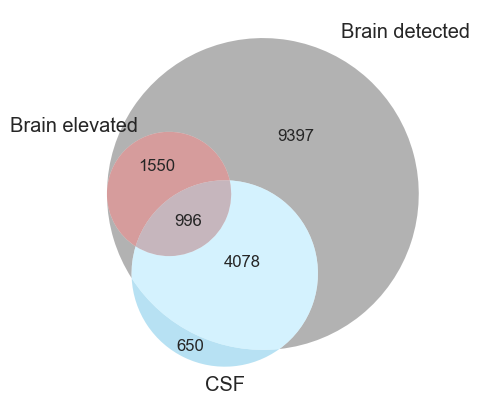

In [48]:
sns.set(style=("ticks"), font_scale=1)
fig, axes = plt.subplots(1, 1, figsize=(5, 5))
colors=("darkred", "grey", "skyblue")
alpha = 0.6

# entire dataset
venn3([brain_elevated_set, brain_detected_set, csf_set], ["Brain elevated", "Brain detected", "CSF"], 
    set_colors=colors, alpha=alpha)

plt.show()
fig.savefig(fig_path + "Venn_diagrams_overlap_brain_detected_CSF.png", bbox_inches="tight")

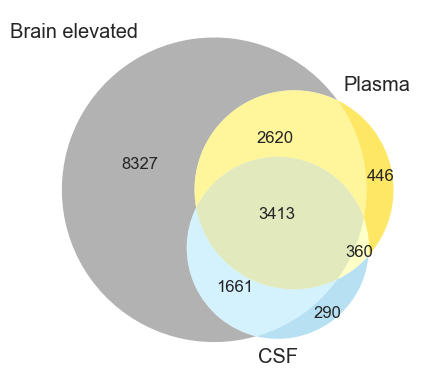

In [49]:
sns.set(style=("ticks"), font_scale=1)
fig, axes = plt.subplots(1, 1, figsize=(5, 5))
colors=("grey", "gold","skyblue")
alpha = 0.6

# entire dataset
venn3([brain_detected_set, plasma_set, csf_set], ["Brain elevated", "Plasma", "CSF"], 
    set_colors=colors, alpha=alpha)

plt.show()
fig.savefig(fig_path + "Venn_diagrams_overlap_brain_detected_plasma_CSF.png", bbox_inches="tight")

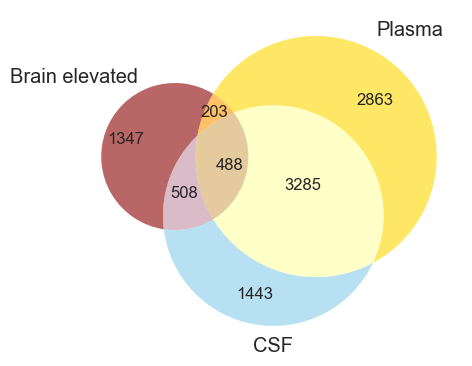

In [50]:
sns.set(style=("ticks"), font_scale=1)
fig, axes = plt.subplots(1, 1, figsize=(5, 5))
colors=("darkred", "gold", "skyblue")
alpha = 0.6

# entire dataset
venn3([brain_elevated_set, plasma_set, csf_set], ["Brain elevated", "Plasma", "CSF"], 
    set_colors=colors, alpha=alpha)

plt.show()
fig.savefig(fig_path + "Venn_diagrams_overlap_brain_elevated_plasma_CSF.png", bbox_inches="tight")

In [51]:
# how big is is the overlap with the brain proteome with increasing study number stringency?
overlap_list = []

for i in range(1, all_csf["#Studies"].max()+1):
    core_csf = set(all_csf[all_csf["#Studies"]>=i]["Uniprot"])
    overlap_core_csf_brain = core_csf.intersection(brain_elevated_set)
    overlap_per = len(overlap_core_csf_brain)/len(core_csf)
    print("Overlap of CSF and brain proteome for proteins found in a minimum of %d studies is: %.3f."
        % (i, overlap_per))
    overlap_list.append(overlap_per)

Overlap of CSF and brain proteome for proteins found in a minimum of 1 studies is: 0.173.
Overlap of CSF and brain proteome for proteins found in a minimum of 2 studies is: 0.202.
Overlap of CSF and brain proteome for proteins found in a minimum of 3 studies is: 0.213.
Overlap of CSF and brain proteome for proteins found in a minimum of 4 studies is: 0.230.
Overlap of CSF and brain proteome for proteins found in a minimum of 5 studies is: 0.247.
Overlap of CSF and brain proteome for proteins found in a minimum of 6 studies is: 0.255.
Overlap of CSF and brain proteome for proteins found in a minimum of 7 studies is: 0.267.
Overlap of CSF and brain proteome for proteins found in a minimum of 8 studies is: 0.259.
Overlap of CSF and brain proteome for proteins found in a minimum of 9 studies is: 0.251.
Overlap of CSF and brain proteome for proteins found in a minimum of 10 studies is: 0.244.
Overlap of CSF and brain proteome for proteins found in a minimum of 11 studies is: 0.258.
Overlap 

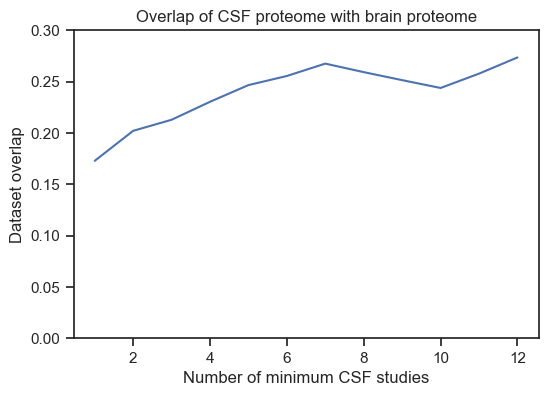

In [52]:
sns.set(style=("ticks"), font_scale=1)
fig, axes = plt.subplots(1, 1, figsize=(6, 4))

sns.lineplot(x=range(1, all_csf["#Studies"].max()+1), y=overlap_list)
plt.ylim((0, 0.3))
plt.xlabel("Number of minimum CSF studies")
plt.ylabel("Dataset overlap")
plt.title("Overlap of CSF proteome with brain proteome")
plt.show()

fig.savefig(fig_path + "Overlap_brain_all_CSF.png", bbox_inches="tight")

In [53]:
# how big is is the overlap with the brain proteome with increasing study number stringency?
overlap_list = []

for i in range(1, csf["#Studies"].max()+1):
    core_csf = set(csf[csf["#Studies"]>=i]["Uniprot"])
    overlap_core_csf_brain = core_csf.intersection(brain_elevated_set)
    overlap_per = len(overlap_core_csf_brain)/len(core_csf)
    print("Overlap of CSF and brain proteome for proteins found in a minimum of %d studies is: %.3f."
          % (i, overlap_per))
    overlap_list.append(overlap_per)

Overlap of CSF and brain proteome for proteins found in a minimum of 1 studies is: 0.174.
Overlap of CSF and brain proteome for proteins found in a minimum of 2 studies is: 0.203.
Overlap of CSF and brain proteome for proteins found in a minimum of 3 studies is: 0.214.
Overlap of CSF and brain proteome for proteins found in a minimum of 4 studies is: 0.234.
Overlap of CSF and brain proteome for proteins found in a minimum of 5 studies is: 0.249.
Overlap of CSF and brain proteome for proteins found in a minimum of 6 studies is: 0.259.
Overlap of CSF and brain proteome for proteins found in a minimum of 7 studies is: 0.283.


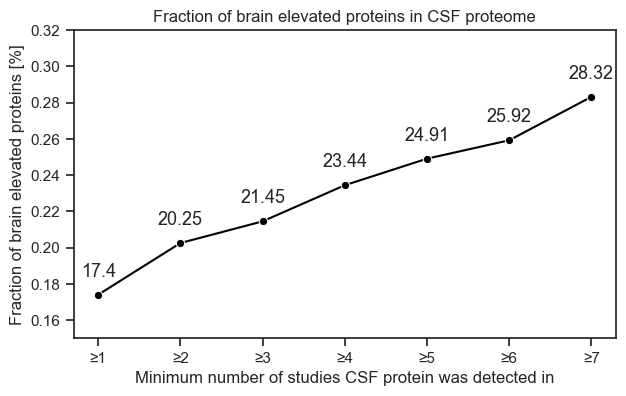

In [56]:
sns.set(style=("ticks"), font_scale=1)
fig, ax = plt.subplots(1, 1, figsize=(7, 4))

# line plot
xlabels = ["≥" + str(i) for i in range(1, csf["#Studies"].max()+1)]
ax = sns.lineplot(x=xlabels, y=overlap_list, marker="o", color="black")
plt.ylim((0.15, 0.32))
plt.xlabel("Minimum number of studies CSF protein was detected in") # how to say this more nicely?
plt.ylabel("Fraction of brain elevated proteins [%]")
plt.title("Fraction of brain elevated proteins in CSF proteome")

# add fraction annotations
for i in range(len(xlabels)):
    ax.text(xlabels[i], overlap_list[i]+0.01, str(round(overlap_list[i]*100, 2)), ha="center", size=13) 
    
plt.show()
fig.savefig(fig_path + "Overlap_brain_CSF.png", bbox_inches="tight")

## Constant CSF proteome

In [35]:
csf_core = csf[csf["#Studies"] == 7]
csf_core_set = set(csf_core["Uniprot"])
print("Number of proteins present in all CSF studies: %d" % len(csf_core))
brain_csf_core = brain_elevated_set.intersection(csf_core_set)
print("Number of brain proteins found in CSF in all 1000+ proteins studies:", len(brain_csf_core))

Number of proteins present in all CSF studies: 572
Number of brain proteins found in CSF in all 1000+ proteins studies: 162


## Factors of mass spectrometry detection probability

In [36]:
def calculate_mw(seq):
    
    PA = ProteinAnalysis(seq)
    # molecular weight
    mw = PA.molecular_weight()
    return mw

def peptide_category(number):
    if number == 0:
        return "0"
    if number == 1:
        return "1"
    if number == 2:
        return "2"
    if number == 3:
        return "3"
    if number == 4:
        return "4"
    if number == 5:
        return "5"
    if number == 6:
        return "6"
    if number == 7:
        return "7"
    if 7 < number < 10:
        return "8-10"
    if 11 <= number < 21:
        return "11-20"
    if number >= 21:
        return "21+"
    
def peptide_to_binary(number):
    if float(number) == 0:
        return "non-CSF"
    if float(number) > 0:
        return "CSF"

### CSF proteins

#### Molecular weight

In [37]:
csf_peptides = csf[["Uniprot", "#Peptides_median", "#Peptides_max", "#Peptides_min"]]
csf_study_num = csf[["Uniprot", "#Studies"]]
brain_exp = brain_elevated[["Uniprot", "Brain expression"]]

In [38]:
# calculate molecular weight for CSF proteins
csf_seq["Molecular weight"] = csf_seq["Sequence"].apply(calculate_mw)
csf_seq["Molecular weight"] = csf_seq["Molecular weight"] / 1000

In [39]:
# convert peptide number into categories
csf_peptides["Number of peptides"] = csf_peptides["#Peptides_median"].apply(peptide_category)

# add molecular weight as a column
csf_peptides_mass = csf_peptides.merge(csf_seq[["Uniprot", "Molecular weight"]], on="Uniprot", 
    how="inner") # some IDs don't match
csf_peptides_mass["log2(Molecular weight)"] = np.log2(csf_peptides_mass["Molecular weight"])

<ipython-input-39-97dd6eeed062>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  csf_peptides["Number of peptides"] = csf_peptides["#Peptides_median"].apply(peptide_category)


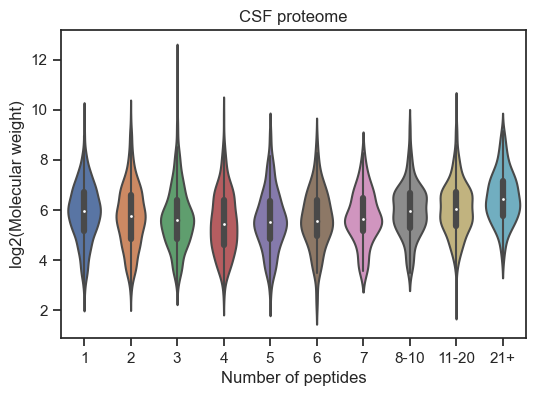

In [40]:
# plot molecular weight vs. number of peptides
sns.set(style=("ticks"), font_scale=1)
fig, axes = plt.subplots(1, 1, figsize=(6, 4))

sns.violinplot(x="Number of peptides",  y="log2(Molecular weight)", data=csf_peptides_mass,
            order=["1", "2", "3", "4", "5","6", "7", "8-10", "11-20","21+"]);
plt.title("CSF proteome")
plt.show()

fig.savefig(fig_path + "Mass_number_of_peptides.png", bbox_inches="tight")

In [41]:
# plot molecular weight vs. number of studies
csf_study_num_mass = csf_study_num.merge(csf_seq[["Uniprot", "Molecular weight"]], on="Uniprot", how="inner") 
csf_study_num_mass["log2(Molecular weight)"] = np.log2(csf_study_num_mass["Molecular weight"])

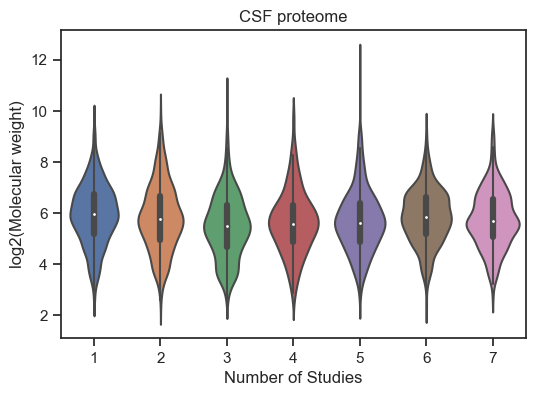

In [42]:
sns.set(style=("ticks"), font_scale=1)
fig, axes = plt.subplots(1, 1, figsize=(6, 4))

sns.violinplot(x="#Studies",  y="log2(Molecular weight)", data=csf_study_num_mass)
plt.xlabel("Number of Studies")
plt.title("CSF proteome")
plt.show()

fig.savefig(fig_path + "Mass_number_of_studies.png", bbox_inches="tight")

### Brain elevated proteins

#### Molecular weight

In [43]:
# calculate molecular weight for brain proteins
brain_seq["Molecular weight"] = brain_seq["Sequence"].apply(calculate_mw)
brain_seq["Molecular weight"] = brain_seq["Molecular weight"] / 1000
brain_seq

,Uniprot,Sequence,Molecular weight
0,Q8TDC3,MSSGAKEGGGGSPAYHLPHPHPHPPQHAQYVGPYRLEKTLGKGQTG...,85.085749
1,P48065,MDGKVAVQECGPPAVSWVPEEGEKLDQEDEDQVKDRGQWTNKMEFV...,69.367518
2,Q9Y250,MGSVSSLISGHSFHSKHCRASQYKLRKSSHLKKLNRYSDGLLRFGF...,66.612157
3,P0DMW5,MAASAALSAAAAAAALSGLAVRLSRSAAARGSYGAFCKGLTRTLLT...,8.388818
4,P21579,MVSESHHEALAAPPVTTVATVLPSNATEPASPGEGKEDAFSKLKEK...,47.572539
...,...,...,...
2541,Q8IZU8,MALMFTGHLLFLALLMFAFSTFEESVSNYSEWAVFTDDIDQFKTQK...,139.235872
2542,Q4JDL3,MSSPRDFRAEPVNDYEGNDSEAEDLNFRETLPSSSQENTPRSKVFE...,48.422327
2543,Q8N4V2,MEEDLFQLRQLPVVKFRRTGESARSEDDTASGEHEVQIEGVHVGLE...,60.768467
2544,P48426,MATPGNLGSSVLASKTKTKKKHFVAQKVKLFRASDPLLSVLMWGVN...,46.224044


In [44]:
csf_peptides_mass_brain_only = csf_peptides.merge(brain_seq[["Uniprot", "Molecular weight"]], on="Uniprot", how="right") 
csf_peptides_mass_brain_only.fillna(0, inplace=True)
csf_peptides_mass_brain_only["Number of peptides"] = csf_peptides_mass_brain_only["#Peptides_median"].apply(peptide_category)
csf_peptides_mass_brain_only["log2(Molecular weight)"] = np.log2(csf_peptides_mass_brain_only["Molecular weight"])

In [45]:
# csf_peptides_mass_brain_only.groupby("Number of peptides").median()["Molecular weight"].reindex(index = 
#     ["0", "1", "2", "3", "4", "5","6", "7", "8-10", "11-20","21+"])

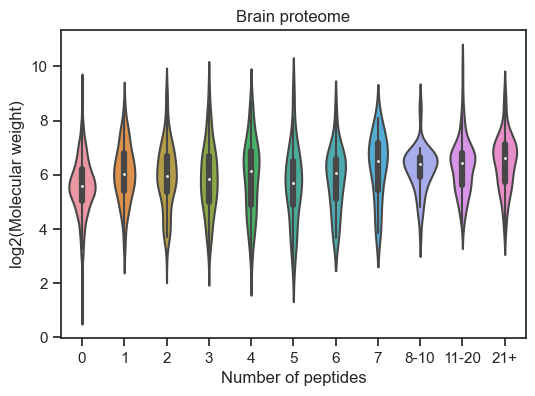

In [46]:
sns.set(style=("ticks"), font_scale=1)
fig, axes = plt.subplots(1, 1, figsize=(6, 4))

sns.violinplot(x="Number of peptides",  y="log2(Molecular weight)", data=csf_peptides_mass_brain_only,
            order=["0", "1", "2", "3", "4", "5", "6", "7", "8-10", "11-20", "21+"]);
plt.title("Brain proteome")
plt.show()

fig.savefig(fig_path + "Mass_number_of_peptides_brain_only.png", bbox_inches="tight")

In [47]:
csf_study_num_mass_brain_only = csf_study_num.merge(brain_seq[["Uniprot", "Molecular weight"]], on="Uniprot", how="right")
csf_study_num_mass_brain_only["log2(Molecular weight)"] = np.log2(csf_study_num_mass_brain_only["Molecular weight"])
csf_study_num_mass_brain_only.fillna(0, inplace=True)

In [48]:
csf_study_num_mass_brain_only.groupby("#Studies").describe()["Molecular weight"]

,count,mean,std,min,25%,50%,75%,max
#Studies,,,,,,,,
0.0,1547.0,62.168172,53.754184,1.974244,32.357183,47.684153,73.260426,595.726062
1.0,303.0,94.290409,80.499077,6.110277,42.709918,76.036328,115.810162,575.885237
2.0,151.0,111.604412,125.948138,6.086255,42.082468,68.358359,126.524042,1011.074206
3.0,67.0,69.505999,48.983455,7.476223,34.060032,61.311563,96.802558,250.790712
4.0,67.0,99.351370,97.622435,7.618398,31.146842,70.100146,114.222876,416.464380
5.0,105.0,97.567598,113.897197,10.169910,38.255516,61.312203,96.367080,560.692650
6.0,140.0,80.198703,55.889205,12.669263,37.676875,73.274976,104.332325,380.034920
7.0,162.0,75.536936,62.624909,6.791339,35.525332,54.246022,100.431574,479.311453


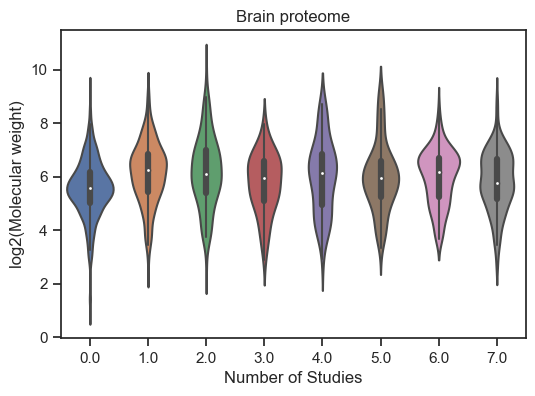

In [49]:
sns.set(style=("ticks"), font_scale=1)
fig, axes = plt.subplots(1, 1, figsize=(6, 4))

sns.violinplot(x="#Studies",  y="log2(Molecular weight)", data=csf_study_num_mass_brain_only)
plt.xlabel("Number of Studies")
plt.title("Brain proteome")
plt.show()

fig.savefig(fig_path + "Mass_number_of_studies_brain_only.png", bbox_inches="tight")

#### Expression

In [50]:
csf_peptides_exp = csf_peptides.merge(brain_exp, on="Uniprot", how="right")
csf_peptides_exp.fillna("0", inplace=True)
csf_peptides_exp["log2(Brain expression)"] = np.log2(csf_peptides_exp["Brain expression"])

In [51]:
# csf_peptides_exp.groupby("Number of peptides").describe()["Brain expression"].reindex(index = 
#     ["0", "1", "2", "3", "4", "5","6", "7", "8-10", "11-20","21+"])

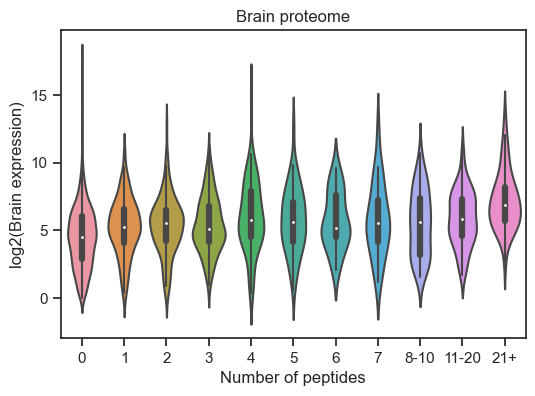

In [52]:
sns.set(style=("ticks"), font_scale=1)
fig, axes = plt.subplots(1, 1, figsize=(6, 4))

sns.violinplot(x="Number of peptides", y="log2(Brain expression)", data=csf_peptides_exp,
            order=["0", "1", "2", "3", "4", "5","6", "7", "8-10", "11-20","21+"]);
plt.title("Brain proteome")
plt.show()

fig.savefig(fig_path + "Expression_number_of_peptides.png", bbox_inches="tight")

In [53]:
csf_study_num_exp = csf_study_num.merge(brain_exp, on="Uniprot", how="right")
csf_study_num_exp["log2(Brain expression)"] = np.log2(csf_study_num_exp["Brain expression"])
csf_study_num_exp.fillna(0, inplace=True)

In [54]:
# csf_study_num_exp.groupby("#Studies").describe()["Brain expression"]

In [55]:
csf_study_num_exp["non-CSF"] = np.where(csf_study_num_exp["#Studies"] == 0, 1, 0)
csf_study_num_exp["CSF"] = np.where(csf_study_num_exp["#Studies"] > 0, 1, 0)
csf_study_num_exp["core CSF"] = np.where(csf_study_num_exp["#Studies"] == 7, 1, 0)
csf_study_num_exp

,Uniprot,#Studies,Brain expression,log2(Brain expression),non-CSF,CSF,core CSF
0,O43612,2.0,352.2,8.460251,0,1,0
1,P51861,0.0,38856.0,15.245850,1,0,0
2,P01185,5.0,5271.0,12.363861,0,1,0
3,Q96PE5,3.0,149.9,7.227857,0,1,0
4,Q9BZE3,0.0,34.3,5.100137,1,0,0
...,...,...,...,...,...,...,...
2541,A4D1E1,0.0,2.2,1.137504,1,0,0
2542,Q05481,0.0,30.4,4.925999,1,0,0
2543,Q8TCW7,0.0,1.3,0.378512,1,0,0
2544,Q96LW9,0.0,43.6,5.446256,1,0,0


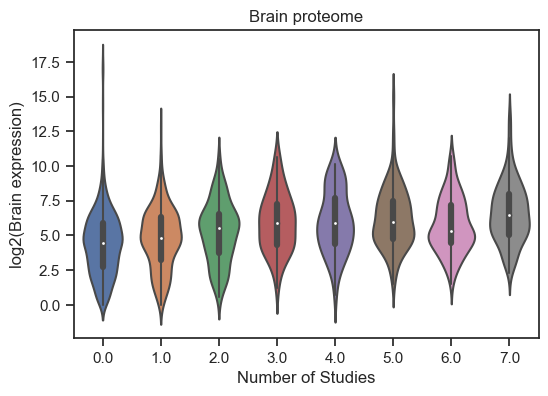

In [56]:
sns.set(style=("ticks"), font_scale=1)
fig, axes = plt.subplots(1, 1, figsize=(6, 4))

sns.violinplot(x="#Studies",  y="log2(Brain expression)", data=csf_study_num_exp)
plt.xlabel("Number of Studies")
plt.title("Brain proteome")
plt.show()

fig.savefig(fig_path + "Expression_number_of_studies.png", bbox_inches="tight")

In [57]:
exp_data = [csf_study_num_exp[csf_study_num_exp["#Studies"] == 0]["log2(Brain expression)"],
csf_study_num_exp[csf_study_num_exp["#Studies"] > 0]["log2(Brain expression)"],
csf_study_num_exp[csf_study_num_exp["#Studies"] == 7]["log2(Brain expression)"]]

print("Median log2(brain expression) of non-CSF proteins: %.2f" % np.median(exp_data[0]))
print("Median log2(brain expression) of CSF proteins: %.2f" % np.median(exp_data[1]))
print("Median log2(brain expression) of core CSF proteins: %.2f" % np.median(exp_data[2]))

Median log2(brain expression) of non-CSF proteins: 4.46
Median log2(brain expression) of CSF proteins: 5.53
Median log2(brain expression) of core CSF proteins: 6.51


In [58]:
# calculate p-values
_, p_nonCSF_CSF = mannwhitneyu(csf_study_num_exp[csf_study_num_exp["#Studies"] == 0]["log2(Brain expression)"],
    csf_study_num_exp[csf_study_num_exp["#Studies"] > 0]["log2(Brain expression)"])
_, p_nonCSF_coreCSF = mannwhitneyu(csf_study_num_exp[csf_study_num_exp["#Studies"] == 0]["log2(Brain expression)"],
    csf_study_num_exp[csf_study_num_exp["#Studies"] == 7]["log2(Brain expression)"])
_, p_CSF_coreCSF = mannwhitneyu(csf_study_num_exp[csf_study_num_exp["#Studies"] > 0]["log2(Brain expression)"],
    csf_study_num_exp[csf_study_num_exp["#Studies"] == 7]["log2(Brain expression)"])

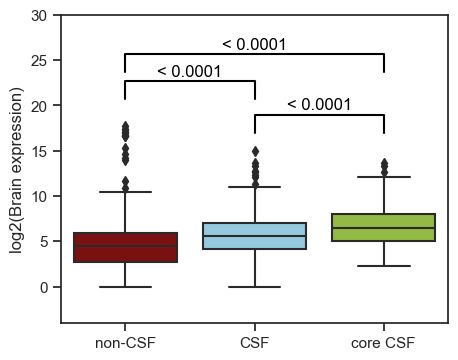

In [71]:
sns.set(style=("ticks"), font_scale=1)
fig, ax = plt.subplots(1, 1, figsize=(5, 4))

sns.boxplot(data=exp_data, palette=["darkred", "skyblue", "yellowgreen"])
ax.set(title="", xlabel=None, ylabel="log2(Brain expression)", xticklabels=["non-CSF", "CSF", "core CSF"], ylim=(-4,30))

# non-CSF vs. CSF
y, h = max(exp_data[0]) + 3, 2
ax.plot([0, 0, 1, 1], [y, y+h, y+h, y], lw=1.5, color="black")
ax.text(0.5, y+2.2, print_p_val(p_nonCSF_CSF), ha="center", va="bottom", color="black")
# CSF vs. core-CSF
y, h = max(exp_data[1]) + 2, 2
ax.plot([1, 1, 2, 2], [y, y+h, y+h, y], lw=1.5, color="black")
ax.text(1.5, y+2.2, print_p_val(p_CSF_coreCSF), ha="center", va="bottom", color="black")
# non-CSF vs. core-CSF
y, h = max(exp_data[0]) + 6, 2
ax.plot([0, 0, 2, 2], [y, y+h, y+h, y], lw=1.5, color="black")
ax.text(1, y+2.2, print_p_val(p_nonCSF_coreCSF), ha="center", va="bottom", color="black")

plt.show()

fig.savefig(fig_path + "Expression_nonCSF_CSF_coreCSF.png", bbox_inches="tight", dpi=300)

### ProteomicsDB

In [60]:
# create list of proteins with evidence on ProteomicsDB
pos = set(ProteomicsDB_evidence_positive.keys())
pos_filtered_low = set([k for k, v in ProteomicsDB_evidence_positive.items() if v > 0])
print("Number of proteins in positive set:", len(pos))
print("Number of proteins in positive set with evidence score of 1 or higher:", len(pos_filtered_low))

Number of proteins in positive set: 18997
Number of proteins in positive set with evidence score of 1 or higher: 16791


In [61]:
csf_2plus_set = set(csf[csf["#Studies"] > 1]["Uniprot"])
csf_3plus_set = set(csf[csf["#Studies"] > 2]["Uniprot"])

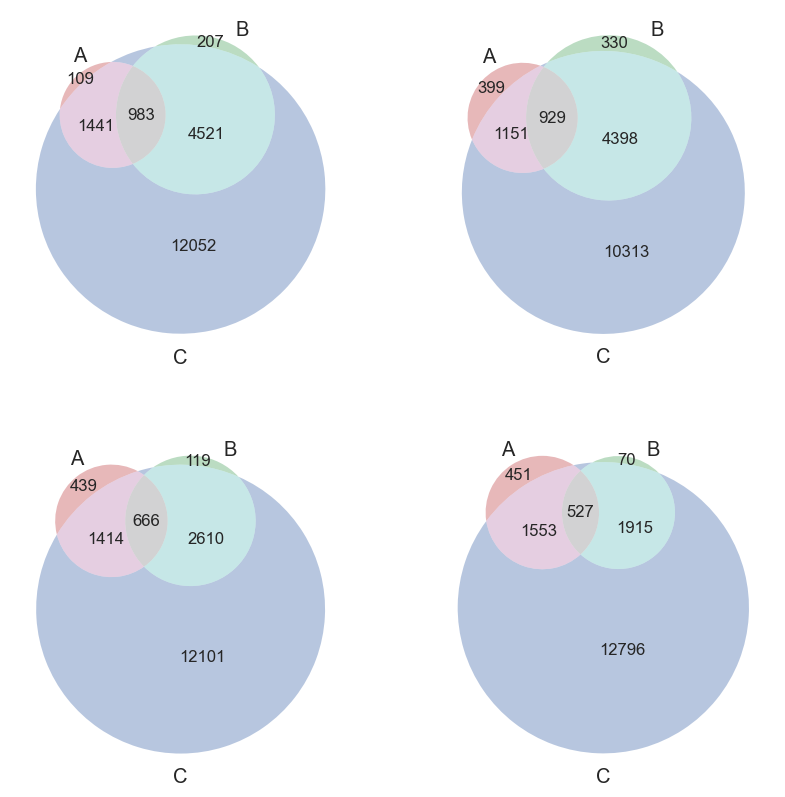

In [62]:
#### TO DO ####
# check why the numbers don't fully match up

sns.set(style=("ticks"), font_scale=1)
fig, ax = plt.subplots(2, 2, figsize=(10,10))

venn3([brain_elevated_set, csf_set, pos], ax=ax[0,0])
venn3([brain_elevated_set, csf_set, pos_filtered_low], ax=ax[0,1])
venn3([brain_elevated_set, csf_2plus_set, pos_filtered_low], ax=ax[1,0])
venn3([brain_elevated_set, csf_3plus_set, pos_filtered_low], ax=ax[1,1])

plt.show()

## Distribution across brain

In [63]:
brain_dist = brain_elevated[["Uniprot", "RNA brain regional distribution"]]
brain_dist

csf_peptides_dist = csf_peptides.merge(brain_dist, on="Uniprot", how="right")
csf_peptides_dist.fillna(0, inplace=True)
csf_peptides_dist["CSF"] = csf_peptides_dist["#Peptides_median"].apply(peptide_to_binary)

In [64]:
dist_count = csf_peptides_dist.groupby("CSF")["RNA brain regional distribution"].value_counts(normalize=True)
dist_count = dist_count.to_frame()
dist_count.columns = ["Fraction"]
dist_count = dist_count.unstack()
dist_count.columns = dist_count.columns.droplevel()
dist_count = dist_count[['Detected in all', 'Detected in many', 'Detected in some', 'Detected in single']]

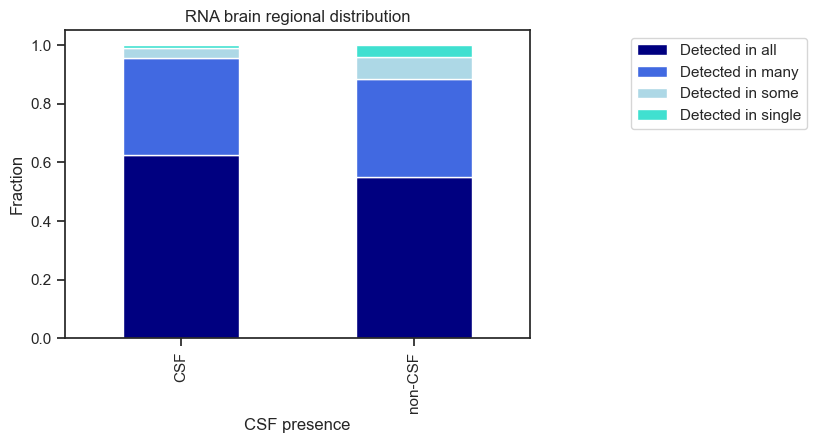

In [65]:
sns.set(style=("ticks"), font_scale=1)
fig, axes = plt.subplots(1, 1, figsize=(6, 4))

dist_count.plot(kind="bar", stacked=True, color=["navy", "royalblue", "lightblue", "turquoise"], ax=axes)
axes.set(xlabel="CSF presence", ylabel="Fraction", title="RNA brain regional distribution")
axes.legend(labels=["Detected in all", "Detected in many", "Detected in some", "Detected in single"], bbox_to_anchor=(1.2, 1))

plt.show()
fig.savefig(fig_path + "Brain_regional_distribution_brain_elevates.png", bbox_inches="tight")

## Comparison of CSF core proteomes

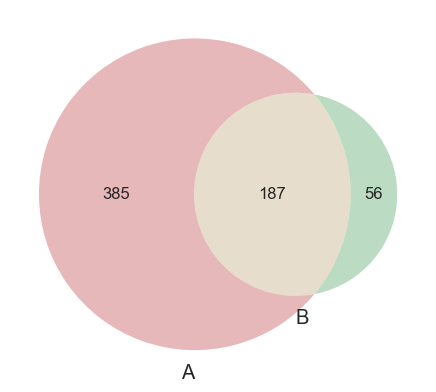

In [66]:
csf_core_schilde2018_set = set(csf_core_schilde2018["Uniprot ID"])

venn2([csf_core_set, csf_core_schilde2018_set])

plt.show()

## Known amyloidogenic proteins

In [67]:
# # import AmyPro entries (https://amypro.net/#/)
# amypro = pd.read_csv(data_path + "Databases/Amypro.txt", sep="\t")
# print("Known human amyloidogenic proteins in AmyPro database: %i" % len(amypro[amypro["alt_names"] == "Homo sapiens"]))

In [68]:
# print("Amyloidogenic proteins in the brain: %i" % len(set(amypro["species"]).intersection(brain_set)))
# print("Amyloidogenic proteins in the brain that are found in CSF: %i" % len(set(amypro["species"]).intersection(brain_csf_yes)))
# for i in set(amypro["species"]).intersection(brain_csf_yes):
#     print(i)

# Save brain protein lists

## CSF positive and negative protein lists (in brain elevated proteome)

In [69]:
with open(data_path + "Brain/Brain_elevated_CSF.txt", "w") as f:
    for item in brain_csf_yes:
        f.write("%s\n" % item)
        
with open(data_path + "Brain/Brain_elevated_non_CSF.txt", "w") as f:
    for item in brain_csf_no:
        f.write("%s\n" % item)

## Constant CSF proteome

In [70]:
with open(data_path + "CSF/constant/CSF_core.txt", "w") as f:
    for item in csf_core["Uniprot"]:
        f.write("%s\n" % item)

NameError: name 'csf_constant' is not defined